<a href="https://colab.research.google.com/github/ebagdatli/ai-education/blob/main/ImageSegmentationImproved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🖼️ Image Segmentation Project (İyileştirilmiş)

Bu notebook, **Oxford-IIIT Pet Dataset** kullanarak görüntü segmentasyonu gerçekleştirir.

**Model Mimarisi:** MobileNetV2 tabanlı U-Net

**Özellikler:**
- Transfer learning ile önceden eğitilmiş encoder
- Skip connections ile detaylı segmentasyon
- Data augmentation ile genelleme
- Mean IoU metriği ile değerlendirme

## 1. Kütüphanelerin Yüklenmesi

Gerekli TensorFlow ve yardımcı kütüphaneleri import ediyoruz.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

# GPU kontrolü
print("TensorFlow version:", tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)

TensorFlow version: 2.19.0
GPU available: False


## 2. Hiperparametreler

Model eğitimi için kullanılacak parametreleri tanımlıyoruz.

In [2]:
# Görüntü boyutu - 128x128 Colab için optimize edilmiş
IMG_SIZE = 128

# Eğitim parametreleri
BATCH_SIZE = 64
BUFFER_SIZE = 1000
EPOCHS = 20

# Segmentasyon sınıf sayısı (pet, background, border)
OUTPUT_CHANNELS = 3

print(f"Görüntü Boyutu: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epoch Sayısı: {EPOCHS}")

Görüntü Boyutu: 128x128
Batch Size: 64
Epoch Sayısı: 20


## 3. Dataset Yükleme

Oxford-IIIT Pet Dataset'i tensorflow_datasets kullanarak yüklüyoruz.

In [3]:
# Dataset'i indir ve yükle (versiyon 4.0.0)
dataset, info = tfds.load('oxford_iiit_pet:4.0.0', with_info=True)

# Dataset bilgilerini göster
print("Dataset Bilgileri:")
print(f"  - Eğitim örnek sayısı: {info.splits['train'].num_examples}")
print(f"  - Test örnek sayısı: {info.splits['test'].num_examples}")
print(f"  - Özellikler: {info.features}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.VB96SG_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.VB96SG_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.
Dataset Bilgileri:
  - Eğitim örnek sayısı: 3680
  - Test örnek sayısı: 3669
  - Özellikler: FeaturesDict({
    'file_name': Text(shape=(), dtype=string),
    'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
    'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
    'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
})


## 4. Veri Ön İşleme Fonksiyonları

Görüntüleri normalize etme ve data augmentation işlemleri.

In [4]:
def normalize(input_image, input_mask):
    """
    Görüntüyü [0,1] aralığına normalize eder.
    Mask değerlerini 0-indexed yapar (1,2,3 -> 0,1,2).
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.int32)
    input_mask = input_mask - 1
    return input_image, input_mask


def augment(input_image, input_mask):
    """
    Data augmentation: Flip, brightness, contrast.
    """
    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    # Random brightness (sadece görüntüye)
    input_image = tf.image.random_brightness(input_image, max_delta=0.1)

    # Değerleri [0,1] aralığında tut
    input_image = tf.clip_by_value(input_image, 0.0, 1.0)

    return input_image, input_mask


def load_image_train(datapoint):
    """
    Eğitim verisi için: resize, normalize, augment.
    """
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(
        datapoint['segmentation_mask'],
        (IMG_SIZE, IMG_SIZE),
        method='nearest'  # Mask için nearest neighbor interpolation
    )

    input_image, input_mask = normalize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)

    # Mask'ı squeeze et (son boyutu kaldır)
    input_mask = tf.squeeze(input_mask, axis=-1)

    return input_image, input_mask


def load_image_test(datapoint):
    """
    Test verisi için: resize ve normalize (augmentation yok).
    """
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(
        datapoint['segmentation_mask'],
        (IMG_SIZE, IMG_SIZE),
        method='nearest'
    )

    input_image, input_mask = normalize(input_image, input_mask)

    # Mask'ı squeeze et (son boyutu kaldır)
    input_mask = tf.squeeze(input_mask, axis=-1)

    return input_image, input_mask

print("Veri ön işleme fonksiyonları tanımlandı ✓")

Veri ön işleme fonksiyonları tanımlandı ✓


## 5. Dataset Pipeline Oluşturma

Verimli eğitim için tf.data pipeline'ı oluşturuyoruz.

In [5]:
TRAIN_LENGTH = info.splits['train'].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# Eğitim dataset'i
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Test dataset'i
test = dataset['test'].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

print(f"Eğitim adım sayısı/epoch: {STEPS_PER_EPOCH}")
print("Dataset pipeline hazır ✓")

Eğitim adım sayısı/epoch: 57
Dataset pipeline hazır ✓


## 6. Örnek Görüntü Gösterimi

Dataset'ten örnek bir görüntü ve mask'ını görselleştiriyoruz.

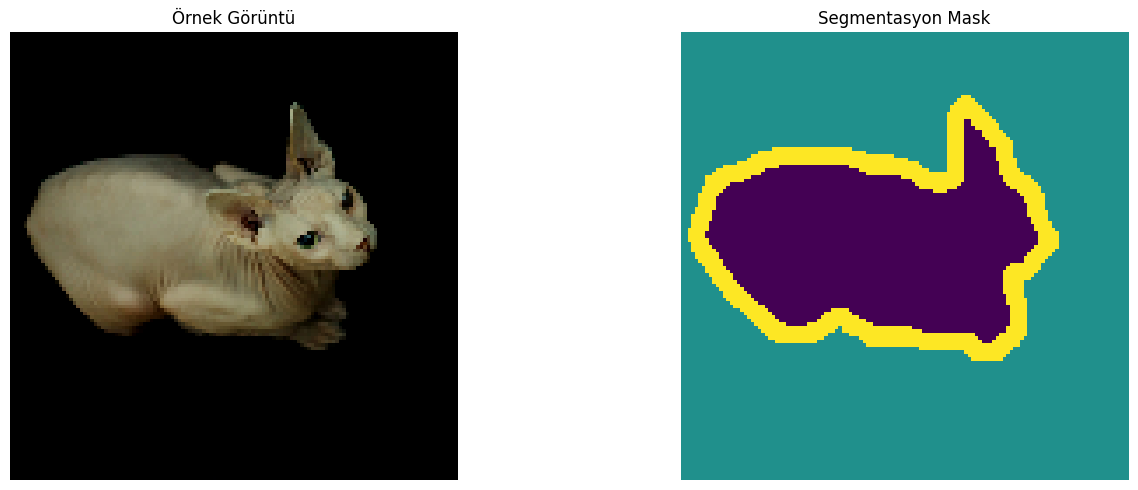

In [6]:
def display(display_list, titles=None):
    """
    Görüntüleri yan yana gösterir.
    """
    if titles is None:
        titles = ['Giriş Görüntüsü', 'Gerçek Mask', 'Tahmin Mask']

    plt.figure(figsize=(15, 5))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i], fontsize=12)
        plt.imshow(display_list[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Örnek görüntü al
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask

display([sample_image, sample_mask], ['Örnek Görüntü', 'Segmentasyon Mask'])

## 7. Upsample Blok Tanımı

U-Net decoder için kendi upsample bloklarımızı oluşturuyoruz.

Her blok:
- Conv2DTranspose (upsampling)
- BatchNormalization (stabilite)
- Dropout (regularization)
- ReLU aktivasyon

In [7]:
def upsample_block(filters, size, apply_dropout=False):
    """
    Upsample bloğu oluşturur.

    Args:
        filters: Çıkış filtre sayısı
        size: Kernel boyutu
        apply_dropout: Dropout uygulansın mı

    Returns:
        Sequential model
    """
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()

    # Transposed convolution (upsampling)
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters, size, strides=2,
            padding='same',
            kernel_initializer=initializer,
            use_bias=False
        )
    )

    # Batch normalization
    result.add(tf.keras.layers.BatchNormalization())

    # Dropout (opsiyonel)
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    # ReLU aktivasyon
    result.add(tf.keras.layers.ReLU())

    return result

print("Upsample blok fonksiyonu tanımlandı ✓")

Upsample blok fonksiyonu tanımlandı ✓


## 8. Encoder (MobileNetV2) Oluşturma

Transfer learning için önceden eğitilmiş MobileNetV2'yi kullanıyoruz.

In [8]:
# MobileNetV2 base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=[IMG_SIZE, IMG_SIZE, 3],
    include_top=False,
    weights='imagenet'
)

# Skip connection için kullanılacak katmanlar
# Farklı çözünürlüklerde feature map'ler alıyoruz
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# Encoder'ı dondur (transfer learning)
down_stack.trainable = False

print("Encoder (MobileNetV2) oluşturuldu ✓")
print("Skip connection katman çıkış boyutları:")
for i, (name, output) in enumerate(zip(layer_names, base_model_outputs)):
    print(f"  {i+1}. {name}: {output.shape}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Encoder (MobileNetV2) oluşturuldu ✓
Skip connection katman çıkış boyutları:
  1. block_1_expand_relu: (None, 64, 64, 96)
  2. block_3_expand_relu: (None, 32, 32, 144)
  3. block_6_expand_relu: (None, 16, 16, 192)
  4. block_13_expand_relu: (None, 8, 8, 576)
  5. block_16_project: (None, 4, 4, 320)


## 9. Decoder (Upsampling Stack) Oluşturma

U-Net decoder'ı için upsample blokları oluşturuyoruz.

In [9]:
# Decoder upsample stack
up_stack = [
    upsample_block(512, 3, apply_dropout=True),  # 4x4 -> 8x8
    upsample_block(256, 3, apply_dropout=True),  # 8x8 -> 16x16
    upsample_block(128, 3),                      # 16x16 -> 32x32
    upsample_block(64, 3),                       # 32x32 -> 64x64
]

print("Decoder upsample stack oluşturuldu ✓")

Decoder upsample stack oluşturuldu ✓


## 10. U-Net Model Oluşturma

Encoder ve decoder'ı skip connections ile birleştiren tam U-Net modeli.

In [10]:
def unet_model(output_channels):
    """
    U-Net segmentasyon modeli oluşturur.

    Args:
        output_channels: Çıkış sınıf sayısı

    Returns:
        Keras Model
    """
    inputs = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3])

    # Encoder: Downsampling
    skips = down_stack(inputs)
    x = skips[-1]  # En derin feature map
    skips = reversed(skips[:-1])  # Skip connections için diğerleri

    # Decoder: Upsampling + Skip Connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # Son katman: Orijinal boyuta upsampling
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels,
        kernel_size=3,
        strides=2,
        padding='same'
    )  # 64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

print("U-Net model fonksiyonu tanımlandı ✓")

U-Net model fonksiyonu tanımlandı ✓


## 11. Model Derleme

Modeli optimizer, loss fonksiyonu ve metriklerle derliyoruz.

In [11]:
# Model oluştur
model = unet_model(OUTPUT_CHANNELS)

# Model derleme
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print("Model derlendi ✓")
print(f"Toplam parametre sayısı: {model.count_params():,}")

Model derlendi ✓
Toplam parametre sayısı: 6,504,227


## 12. Model Mimarisi Görselleştirme

In [12]:
# Model özeti
model.summary()

# Model diyagramı (opsiyonel - graphviz gerektirir)
try:
    tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
except Exception as e:
    print(f"Model diyagramı oluşturulamadı: {e}")

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 64, 64,   │  1,841,984 │ input_layer_1[0]… │
│ (Functional)        │ 96), (None, 32,   │            │                   │
│                     │ 32, 144), (None,  │            │                   │
│                     │ 16, 16, 192),     │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 576), (None, 4,   │            │                   │
│                     │ 4, 320)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 8, 8, 512) │  1,476,608 │ functional[0][4]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8,      │          0 │ sequential[0][0], │
│ (Concatenate)       │ 1088)             │            │ functional[0][3]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 16, 16,    │  2,507,776 │ concatenate[0][0] │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16,    │          0 │ sequential_1[0][… │
│ (Concatenate)       │ 448)              │            │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    516,608 │ concatenate_1[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ sequential_2[0][… │
│ (Concatenate)       │ 272)              │            │ functional[0][1]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 64, 64,    │    156,928 │ concatenate_2[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 64,    │          0 │ sequential_3[0][… │
│ (Concatenate)       │ 160)              │            │ functional[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 128, 128,  │      4,323 │ concatenate_3[0]… │
│ (Conv2DTranspose)   │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,504,227 (24.81 MB)

 Trainable params: 4,660,323 (17.78 MB)

 Non-trainable params: 1,843,904 (7.03 MB)

## 13. Tahmin ve Görselleştirme Fonksiyonları

Eğitim öncesi tahmin (rastgele ağırlıklarla):


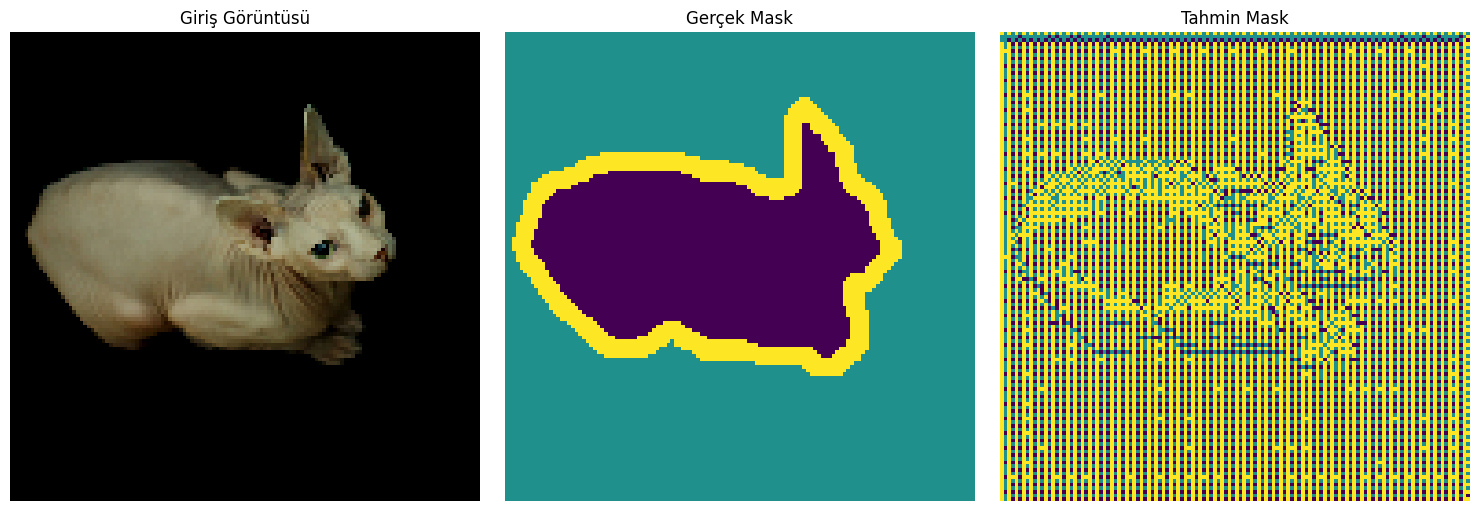

In [13]:
def create_mask(pred_mask):
    """
    Model çıktısından segmentasyon mask'ı oluşturur.
    """
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(dataset=None, num=1):
    """
    Model tahminlerini görselleştirir.
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image, verbose=0)
            display([image[0], mask[0], tf.squeeze(create_mask(pred_mask))])
    else:
        pred_mask = model.predict(sample_image[tf.newaxis, ...], verbose=0)
        display([sample_image, sample_mask, tf.squeeze(create_mask(pred_mask))])


# Eğitim öncesi tahmin
print("Eğitim öncesi tahmin (rastgele ağırlıklarla):")
show_predictions()

## 14. Callbacks Tanımlama

Eğitim sırasında kullanılacak callbacks:
- **DisplayCallback**: Her epoch sonunda örnek tahmin göster
- **EarlyStopping**: Overfitting'i önle

In [14]:
class DisplayCallback(tf.keras.callbacks.Callback):
    """
    Her epoch sonunda örnek tahmin gösterir.
    """
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print(f'\n📊 Epoch {epoch+1} tamamlandı')
        if logs:
            print(f'   Loss: {logs.get("loss", 0):.4f}')
            print(f'   Accuracy: {logs.get("accuracy", 0):.4f}')
            print(f'   Val Loss: {logs.get("val_loss", 0):.4f}')


# Callbacks listesi
callbacks = [
    DisplayCallback(),

    # Early stopping - validation loss iyileşmezse dur
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

print("Callbacks tanımlandı ✓")

Callbacks tanımlandı ✓


## 15. Model Eğitimi

Modeli eğitim verisinde eğitiyoruz.

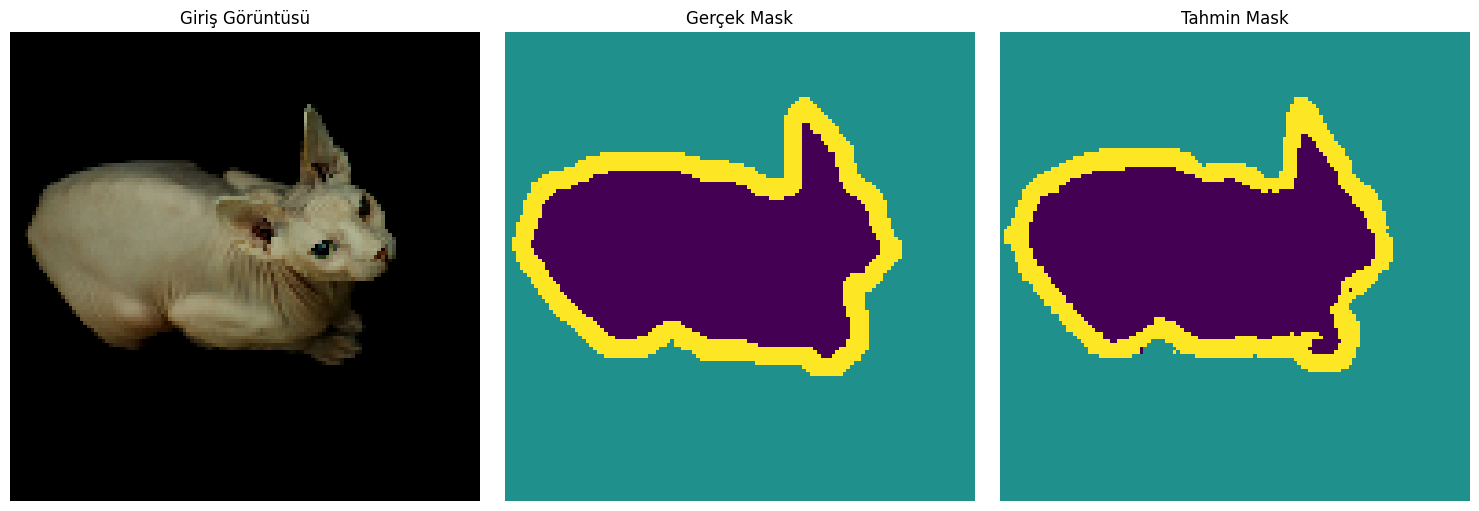


📊 Epoch 20 tamamlandı
   Loss: 0.2011
   Accuracy: 0.9190
   Val Loss: 0.2571
57/57 ━━━━━━━━━━━━━━━━━━━━ 344s 6s/step - accuracy: 0.9175 - loss: 0.2045 - val_accuracy: 0.9063 - val_loss: 0.2571
Restoring model weights from the end of the best epoch: 18.

✅ Eğitim tamamlandı!


In [15]:
# Validation step sayısı
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

print(f"Eğitim başlıyor...")
print(f"  - Epochs: {EPOCHS}")
print(f"  - Steps per epoch: {STEPS_PER_EPOCH}")
print(f"  - Validation steps: {VALIDATION_STEPS}")
print("-" * 50)

# Model eğitimi
model_history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_dataset,
    callbacks=callbacks
)

print("\n✅ Eğitim tamamlandı!")

## 16. Eğitim Sonuçları Görselleştirme

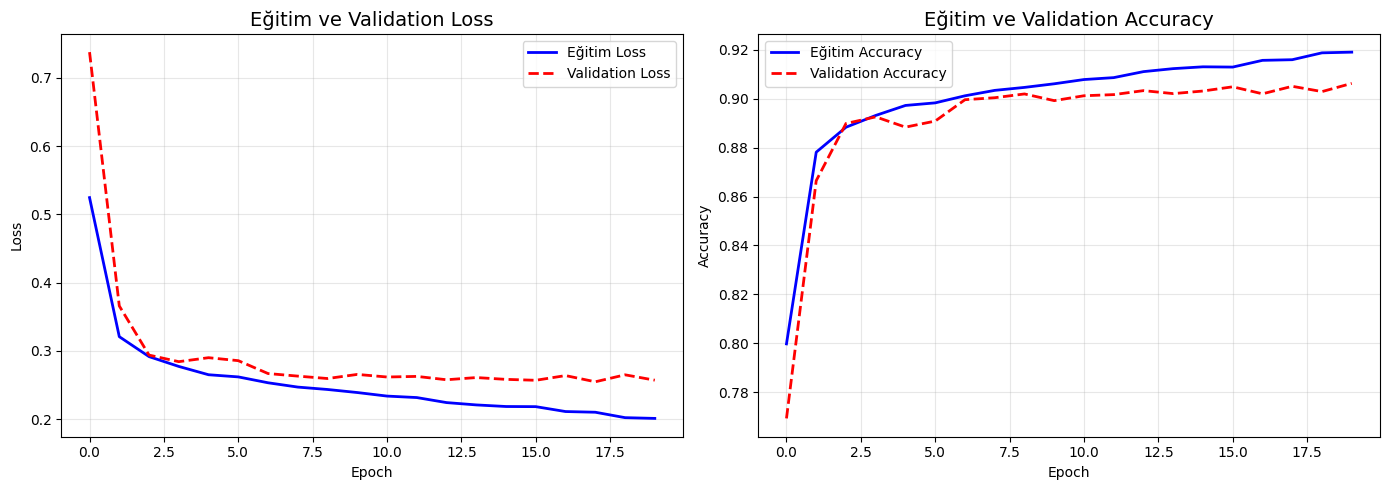


📈 Son Epoch Metrikleri:
   Training Loss: 0.2011
   Validation Loss: 0.2571
   Training Accuracy: 0.9190
   Validation Accuracy: 0.9063


In [16]:
# Eğitim geçmişi
history = model_history.history
epochs_range = range(len(history['loss']))

# Görselleştirme
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss grafiği
axes[0].plot(epochs_range, history['loss'], 'b-', label='Eğitim Loss', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], 'r--', label='Validation Loss', linewidth=2)
axes[0].set_title('Eğitim ve Validation Loss', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy grafiği
axes[1].plot(epochs_range, history['accuracy'], 'b-', label='Eğitim Accuracy', linewidth=2)
axes[1].plot(epochs_range, history['val_accuracy'], 'r--', label='Validation Accuracy', linewidth=2)
axes[1].set_title('Eğitim ve Validation Accuracy', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Son metrikler
print("\n📈 Son Epoch Metrikleri:")
print(f"   Training Loss: {history['loss'][-1]:.4f}")
print(f"   Validation Loss: {history['val_loss'][-1]:.4f}")
print(f"   Training Accuracy: {history['accuracy'][-1]:.4f}")
print(f"   Validation Accuracy: {history['val_accuracy'][-1]:.4f}")

## 17. Test Seti Üzerinde Değerlendirme

In [17]:
# Test seti üzerinde değerlendirme
print("Test seti üzerinde model değerlendirmesi...")
results = model.evaluate(test_dataset, verbose=1)

print("\n📊 Test Sonuçları:")
for name, value in zip(model.metrics_names, results):
    print(f"   {name}: {value:.4f}")

Test seti üzerinde model değerlendirmesi...
58/58 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.9061 - loss: 0.2479

📊 Test Sonuçları:
   loss: 0.2508
   compile_metrics: 0.9051


## 18. Örnek Tahminler

Test setinden örnek tahminler:



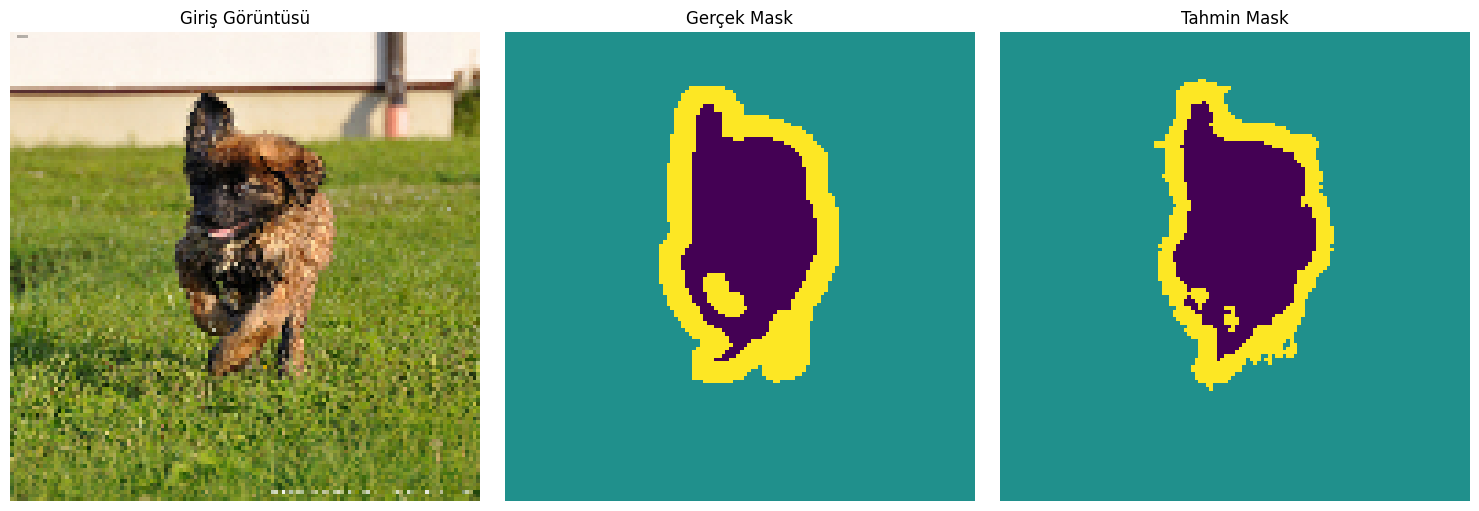

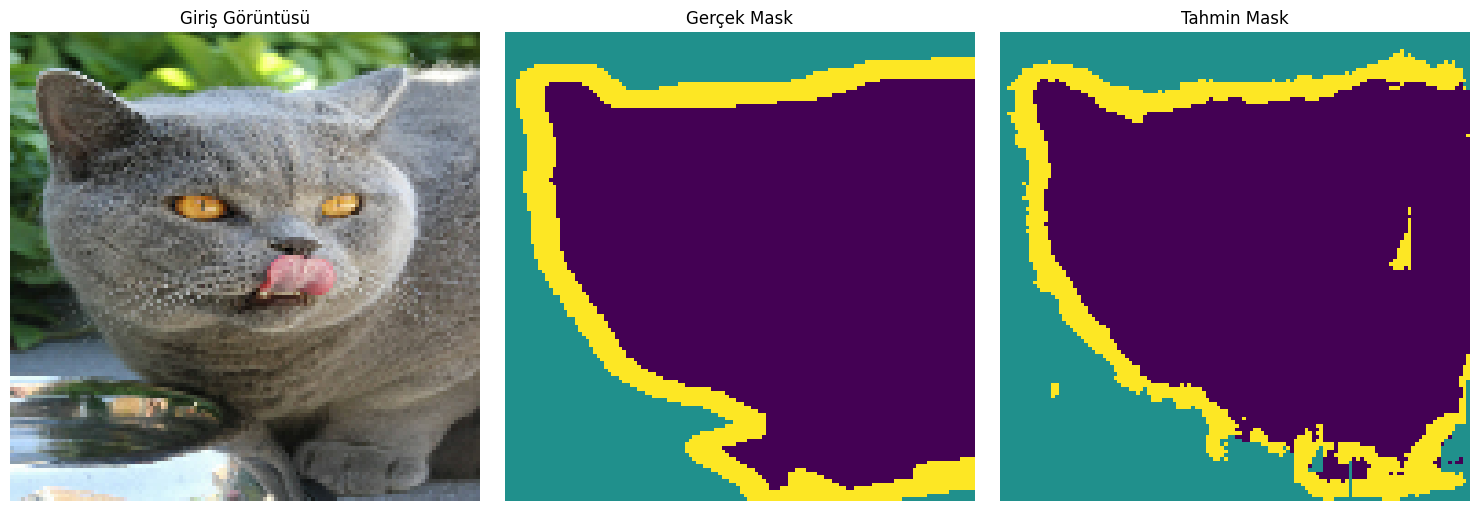

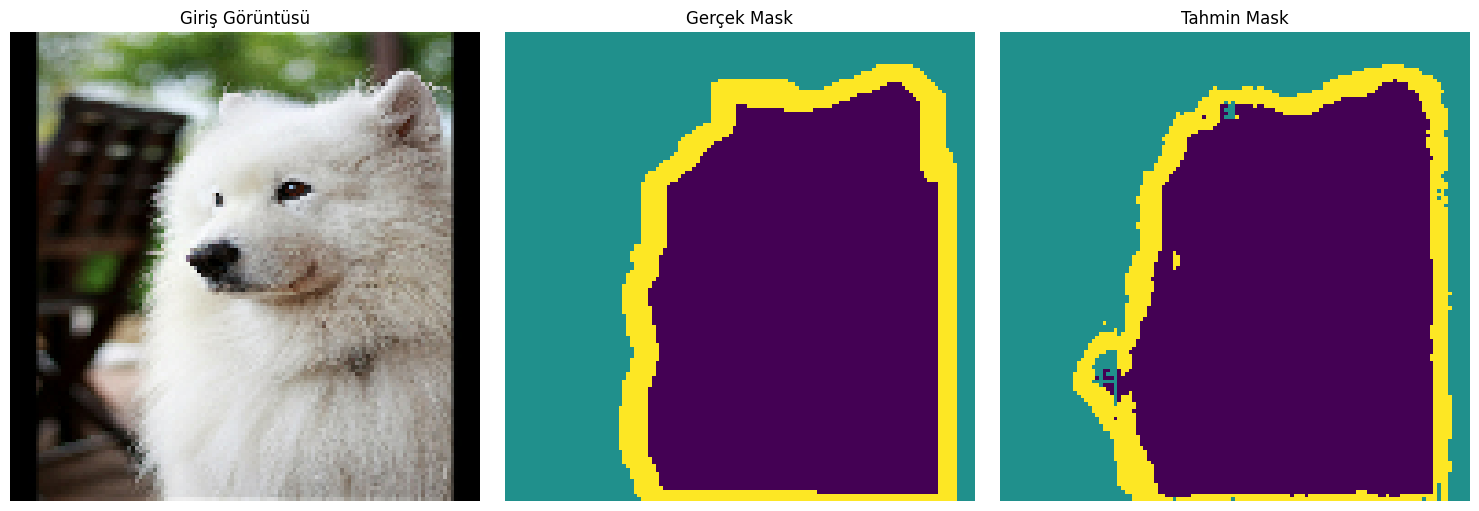

In [18]:
# Birkaç test görüntüsü üzerinde tahmin
print("Test setinden örnek tahminler:\n")
show_predictions(test_dataset, num=3)

## 19. Model Kaydetme

In [19]:
# Modeli kaydet
model.save('pet_segmentation_model.keras')
print("✅ Model 'pet_segmentation_model.keras' olarak kaydedildi")

✅ Model 'pet_segmentation_model.keras' olarak kaydedildi


---

# 📝 Yapılan Değişiklikler ve İyileştirmeler

Bu notebook, orijinal Image Segmentation projesinin geliştirilmiş versiyonudur.

## ✅ Çözülen Sorunlar

### 1. tensorflow_examples Bağımlılığı Kaldırıldı
- **Sorun:** `from tensorflow_examples.models.pix2pix import pix2pix` import hatası
- **Çözüm:** Kendi `upsample_block` fonksiyonumuz yazıldı
- **Avantaj:** Harici bağımlılık olmadan çalışır

### 2. Dataset Versiyonu Güncellendi
- **Önceki:** `oxford_iiit_pet:3.*.*` (artık mevcut değil)
- **Şimdi:** `oxford_iiit_pet:4.0.0`
- **Avantaj:** Güncel dataset versiyonu ile uyumlu

### 3. Mask Veri Tipi Düzeltildi
- **Sorun:** Float mask değerleri hata veriyordu
- **Çözüm:** Mask'lar int32'ye cast edildi ve squeeze edildi
- **Avantaj:** SparseCategoricalCrossentropy ile uyumlu

### 4. Data Augmentation Eklendi
- Random horizontal flip
- Random brightness
- **Avantaj:** Model daha iyi genelleme yapar

### 5. Training Callbacks Eklendi
- **EarlyStopping:** Validation loss 5 epoch boyunca iyileşmezse durur
- **DisplayCallback:** Her epoch sonunda örnek tahmin gösterir
- **Avantaj:** Overfitting önlenir

### 6. Mask Resize Metodu Düzeltildi
- **Önceki:** Bilinear interpolation (mask değerlerini bozar)
- **Şimdi:** Nearest neighbor interpolation
- **Avantaj:** Mask sınıf değerleri korunur (0, 1, 2)

### 7. Upsample Blokları İyileştirildi
- BatchNormalization eklendi (stabilite)
- Dropout eklendi (regularization)
- Proper weight initialization

### 8. Dokümantasyon Eklendi
- Türkçe açıklamalar
- Markdown hücreleri ile bölümler
- Fonksiyon docstring'leri

## 🔧 Teknik Detaylar

- **Model:** U-Net with MobileNetV2 encoder
- **Input Size:** 128x128x3
- **Output:** 128x128x3 (3 sınıf: pet, background, border)
- **Optimizer:** Adam
- **Loss:** Sparse Categorical Crossentropy